### First add the data functions to the path

In [1]:
import sys
import numpy as np
import pandas as pd
import xarray as xr
import copy
import seaborn as sns
from netCDF4 import Dataset
from pathlib import Path
from datetime import datetime, timedelta
notebook_dir = !pwd # Replace with !echo %cd% if using windows
library_dir = Path(notebook_dir[0]).parent.absolute()
sys.path.append(str(library_dir))
data_raw_path = library_dir / 'data' / 'raw' / 'adcp'
glider_raw_path = library_dir / 'data' / 'raw' / 'glider'
fig_path = library_dir / 'reports' / 'figures'
from src.data.adcp_mission_analysis import adcp_import_data, add_dive_averages, read_glider_nc, edgetocentre
#from src.data.beam_mapping import beam2enu, beam_from_center, caltran

def savefig(figname, extension="png"):
    plt.savefig(
        fig_path / str(figname + "." + extension),
        format=extension,
        dpi="figure",
        bbox_inches="tight",
    )

Use better plotting defaults

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
style_path = library_dir / 'src' / 'visualization' / 'presentation.mplstyle'
style.use(str(style_path))

### Load the data into Python

In [3]:
overview, mission_dict = adcp_import_data(data_raw_path)


/home/callum/anaconda3/envs/adcp-glider/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/media/callum/storage/Documents/adcp-glider/src/data/adcp_mission_analysis.py:457: RuntimeWarning: Mean of empty slice
  vel_referenced = vel - np.tile(np.nanmean(vel, 0) - ref_vel, (len(bin_centers), 1))


Add beam attributes. These are taken from the fifth cell (11.3 m from the glider on default settings) and averaged over each ascent/descent profile

In [5]:
beam_attrs, adcp_df = add_dive_averages(overview, mission_dict)
beam_attrs
# overview.join(beam_attrs)

,cor_beam_1,cor_beam_2,cor_beam_3,cor_beam_4,amp_beam_1,amp_beam_2,amp_beam_3,amp_beam_4,beam_miss,pitch,roll,heading,good_angle_5,good_angle_all,good_cor_5,good_cor_all
0000a,NaN,3.266667,3.000000,3.400000,NaN,27.466667,27.100000,27.200000,3.095026,-46.674664,4.855333,127.181343,0.000000,0.000000,0.000000,0.000000
0001a,NaN,20.106383,16.425532,17.212766,NaN,29.670213,29.042553,29.351064,2.697399,-42.630852,4.440851,235.983398,6.382979,6.382979,16.879433,13.049645
0001b,46.821429,48.857143,NaN,46.321429,33.696429,33.294643,NaN,32.857143,1.875847,-12.929286,4.590000,184.708572,32.142857,5.357143,47.857143,36.428571
0002a,NaN,63.545455,62.800000,62.709091,NaN,34.881818,34.563636,34.345455,1.607731,-29.559093,5.614909,115.971268,40.000000,38.181818,66.545455,48.404040
0002b,88.183333,87.666667,NaN,86.350000,37.816667,37.258333,NaN,36.741667,0.898507,16.158834,5.542000,134.029495,60.000000,48.333333,92.555556,66.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0153b,96.581395,96.069767,NaN,95.697674,42.767442,42.116279,NaN,41.523256,0.777380,25.423719,2.500698,106.601860,83.720930,0.000000,99.379845,84.702842
0154a,NaN,92.705882,93.235294,94.705882,NaN,39.029412,40.470588,39.705882,1.549429,-26.010000,3.985883,35.480000,47.058824,5.882353,99.215686,74.248366
0154b,95.785714,95.142857,NaN,95.142857,41.714286,41.000000,NaN,40.642857,0.983536,24.104288,4.052857,97.740715,64.285714,0.000000,99.523810,82.222222
0155a,NaN,93.888889,91.925926,93.592593,NaN,39.648148,40.092593,39.000000,1.377177,-26.317038,4.590370,180.342194,33.333333,0.000000,99.506173,76.131687


In [ ]:
adcp_df.head()

Check that the data start when you expect. The first file in particular may have data from a previous sim dive or bench test. adapt the following cell to select the data starting on the correct day

In [ ]:
# For this dataset, need to remove the data before 23 Jan they are from 2019 benchtests and 2020 sim dives
adcp_df = adcp_df['2020-01-23':]

In [ ]:
beam_attrs.plot(subplots=True,figsize=(20,40),marker='o');
savefig('beam_attributes')

In [ ]:
len(np.arange(0,len(beam_attrs.index), 0.5)

### Print some key QC parameters from each dive limb

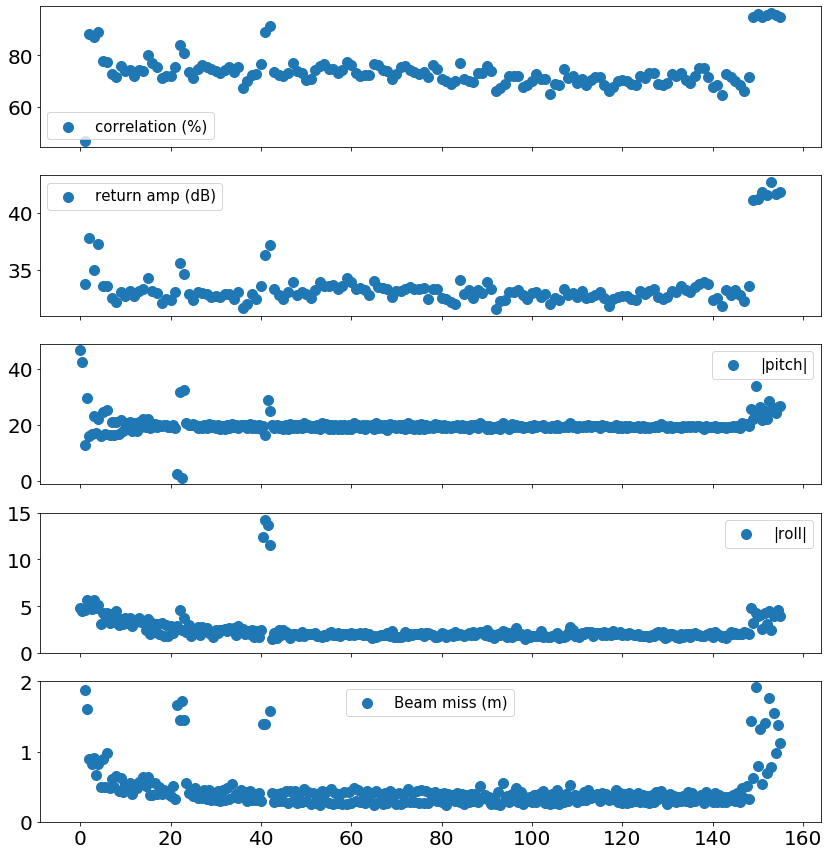

In [6]:
fig, ax = plt.subplots(5,1, sharex=True, figsize=(14,15))
ax = ax.ravel()
ax[0].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), beam_attrs.cor_beam_1, label='correlation (%)')
ax[1].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), beam_attrs.amp_beam_1, label='return amp (dB)')
ax[2].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), np.abs(beam_attrs.pitch), label='|pitch|')
ax[3].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), beam_attrs.roll, label='|roll|')
ax[3].set(ylim = [0,15])
ax[4].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), beam_attrs.beam_miss, label='Beam miss (m)')
ax[4].set(ylim = [0,2])
for axi in ax:
    axi.legend()
savefig('beam_attrs_short')

See which variables are correlated between the dive limbs

In [ ]:
attr_corr = beam_attrs.corr()
mask = np.triu(np.ones_like(attr_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 22))
sns.heatmap(attr_corr, cmap='RdBu_r', vmin=-1,vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Load in glider attitude data for comparison with that from the ADCP

In [ ]:
glider_df = read_glider_nc(glider_raw_path / 'sg637_var_by_var_timeseries.nc')
glider_df

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(glider_df.index, glider_df.pressure, label='glider', s=1)
ax.scatter(adcp_df.index, adcp_df.pressure_ad, label='adcp', s=1)
ax.set(xlim=[datetime(2020,1,24,0), datetime(2020,1,24,12)],ylim = [-10,750], ylabel='Pressure (dbar)')
ax.legend()
savefig('pressure_glider_vs_adcp')

### Attitude comparison. A mismatch may indicate physcal misalignment of the glider and ADCP or a poor calibration of the accelerometers in either unit.

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(20,26), sharex=True)
ax = ax.ravel()
ax[0].scatter(glider_df.index, glider_df.pitch, label='glider')
ax[0].scatter(adcp_df.index, adcp_df.pitch_ad, label='adcp')
ax[0].set(xlim=[datetime(2020,1,24,0), datetime(2020,1,24,12)], ylim=[-30,30], ylabel='Pitch')
ax[1].scatter(glider_df.index, glider_df.roll)
ax[1].scatter(adcp_df.index, adcp_df.roll_ad)
ax[1].set(ylim=[-20,20], ylabel='Roll')
ax[2].scatter(glider_df.index, glider_df.heading)
ax[2].scatter(adcp_df.index, adcp_df.heading_ad)
ax[2].set(ylim=[50,200], ylabel='Heading')
ax[0].legend();
savefig('attitude_glider_vs_adcp')

In [ ]:
glider_av_df = glider_df.groupby('dive', as_index=False).mean()
glider_av_df

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(16,14), sharex=True)
ax = ax.ravel()
ax[0].scatter(glider_av_df.dive_num, glider_av_df.DAC_u)
ax[1].scatter(glider_av_df.dive_num, glider_av_df.DAC_v)
ax[0].set(ylabel='DAC u $(\mathrm{m\ s^{-1}})$', ylim=[-0.2, 0.2])
ax[1].set(ylabel='DAC v $(\mathrm{m\ s^{-1}})$', xlabel='Dive number', ylim=[-0.2, 0.2])
savefig('DAC_by_dive')

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(16,14), sharex=True)
ax = ax.ravel()
ax[0].scatter(glider_av_df.heading, glider_av_df.DAC_u)
ax[1].scatter(glider_av_df.heading, glider_av_df.DAC_v)
ax[0].set(ylabel='DAC u $(\mathrm{m\ s^{-1}})$', ylim=[-0.2, 0.2])
ax[1].set(ylabel='DAC v $(\mathrm{m\ s^{-1}})$', xlabel='Mean heading', ylim=[-0.2, 0.2], xlim=[0,360])
savefig('DAC_by_heading')

In [ ]:
dive_vel[:,1,0][:-1]

In [ ]:
dive = mission_dict['0041a']
flagger = copy.deepcopy(dive.flag_bad_data)
for cell in range(np.size(flagger,1)):
    flagger[:,cell,:] = flagger[:,3,:]
dive_vel = copy.deepcopy(dive.vel_xyz)
dive_vel[:,1,0][:-1]

In [ ]:
ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,0][:-1], label='x')

In [ ]:
dive_vel[:,cell,0]

In [ ]:
mission_dict['0041b'].flag_bad_data[:,3,:]

In [ ]:
sub_df = asc_df[asc_df.dive_no== 41.0]
sub_df.describe()

In [ ]:
des_df.describe()

In [ ]:
asc_df.describe()

In [ ]:
sub_df = asc_df[asc_df.dive_no== 41.0]
sub_df.describe()asc_df.corr()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,10), sharey=True)
ax = ax.ravel()
ax[0].scatter(-des_df.u, des_df.w_from_p, s = 0.5, label='Dive')
ax[0].scatter(-asc_df.u, asc_df.w_from_p, s = 0.5, label='Climb')
ax[0].set(xlim=[0, 0.6], ylim=[-0.3, 0.3], xlabel='Glider forward speed from ADCP', ylabel='Vertical speed from pressure')
ax[0].legend()

ax[1].scatter(-des_df.v, des_df.w_from_p, s = 0.5, label='Dive')
ax[1].scatter(-asc_df.v, asc_df.w_from_p, s = 0.5, label='Climb')
ax[1].set(xlim=[-0.2,0.2], ylim=[-0.3, 0.3], xlabel='Glider cross speed from ADCP')
savefig('all_speed_pressure')


In [ ]:
g = sns.jointplot(des_df.u, des_df.w_from_p, height=12, space=0, xlim=(-0.6, 0.0), ylim=(-0.3, -0.04))
savefig('seaborn_den_scat')

In [ ]:
g = sns.jointplot(asc_df.u, asc_df.w_from_p, kind="kde", height=12, space=0, xlim=(-1, 0.2), ylim=(0.06, 0.14))

In [ ]:
asc_df.corr()

Plot the xyz velocites from one dive cycle. Upper panel dive, lower panel climb

In [7]:
foo = mission_dict['0061a']
bar = mission_dict['0061b']

Plot velocities beam by beam

/home/callum/anaconda3/envs/adcp-glider/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


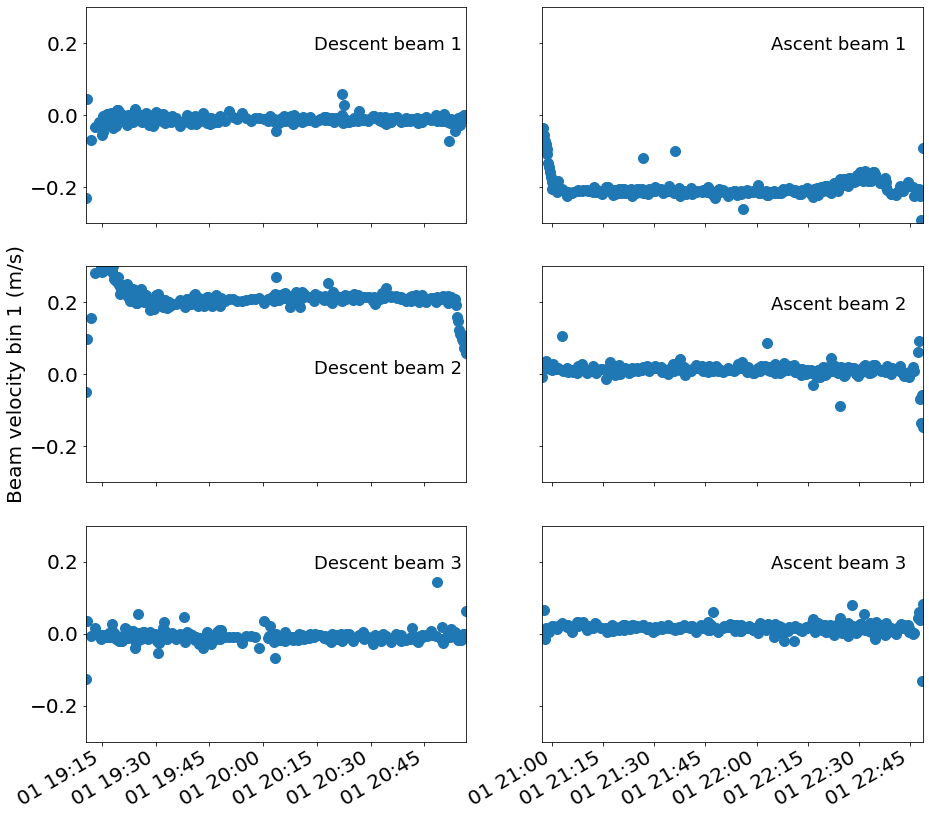

In [8]:
v_lim = 0.3
fig,ax = plt.subplots(3,2,figsize=(15,15), sharex='col', sharey='row')
ax = ax.ravel()
ax[0].scatter(foo.time,foo.vel_beam[:,0,0])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[1].scatter(bar.time,bar.vel_beam[:,0,0])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[2].scatter(foo.time,foo.vel_beam[:,0,1])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[3].scatter(bar.time,bar.vel_beam[:,0,1])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[4].scatter(foo.time,foo.vel_beam[:,0,2])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[5].scatter(bar.time,bar.vel_beam[:,0,2])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)

ax[0].set(ylim=[-v_lim, v_lim])
ax[2].set(ylim=[-v_lim, v_lim], ylabel='Beam velocity bin 1 (m/s)')
ax[4].set(xlim=[foo.time[0], foo.time[-1]], ylim=[-v_lim, v_lim])
ax[5].set(xlim=[bar.time[0], bar.time[-1]])

ax[0].text(0.6, 0.8, 'Descent beam 1',transform=ax[0].transAxes)
ax[1].text(0.6, 0.8, 'Ascent beam 1',transform=ax[1].transAxes)
ax[2].text(0.6, 0.5, 'Descent beam 2',transform=ax[2].transAxes)
ax[3].text(0.6, 0.8, 'Ascent beam 2',transform=ax[3].transAxes)
ax[4].text(0.6, 0.8, 'Descent beam 3',transform=ax[4].transAxes)
ax[5].text(0.6, 0.8, 'Ascent beam 3',transform=ax[5].transAxes)
fig.autofmt_xdate()
#savefig('beam_velocities')

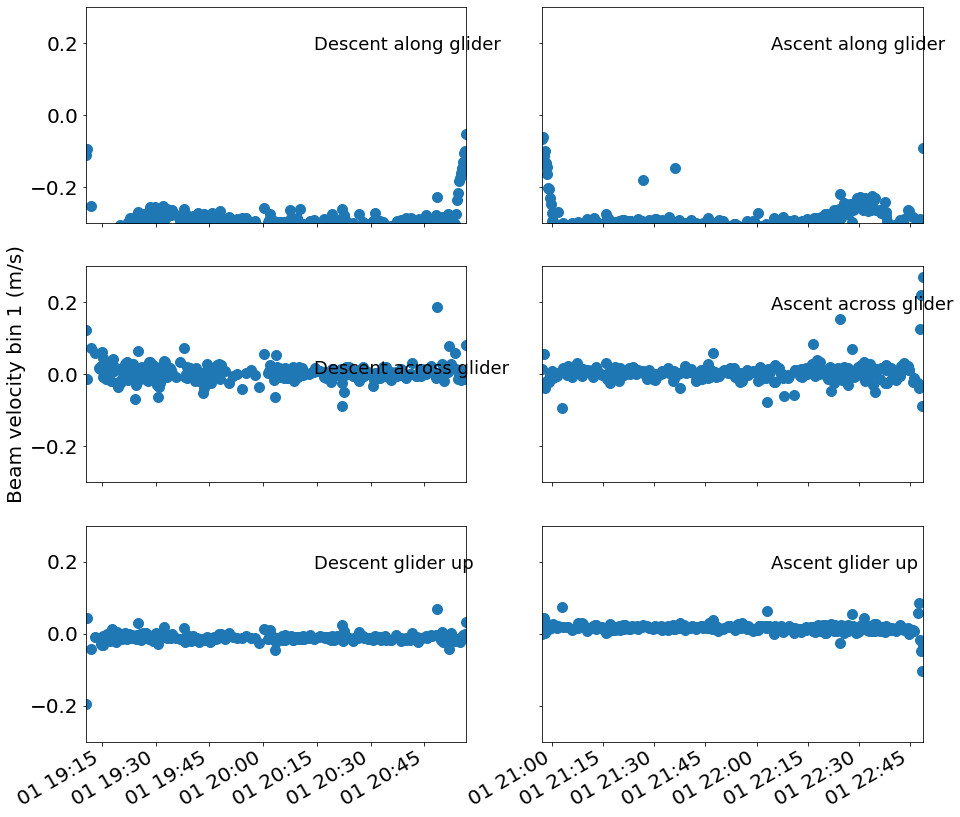

In [13]:
v_lim = 0.3
fig,ax = plt.subplots(3,2,figsize=(15,15), sharex='col', sharey='row')
ax = ax.ravel()
ax[0].scatter(foo.time,foo.vel_xyz[:,0,0])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[1].scatter(bar.time,bar.vel_xyz[:,0,0])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[2].scatter(foo.time,foo.vel_xyz[:,0,1])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[3].scatter(bar.time,bar.vel_xyz[:,0,1])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[4].scatter(foo.time,foo.vel_xyz[:,0,2])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[5].scatter(bar.time,bar.vel_xyz[:,0,2])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)

ax[0].set(ylim=[-v_lim, v_lim])
ax[2].set(ylim=[-v_lim, v_lim], ylabel='Beam velocity bin 1 (m/s)')
ax[4].set(xlim=[foo.time[0], foo.time[-1]], ylim=[-v_lim, v_lim])
ax[5].set(xlim=[bar.time[0], bar.time[-1]])

ax[0].text(0.6, 0.8, 'Descent along glider',transform=ax[0].transAxes)
ax[1].text(0.6, 0.8, 'Ascent along glider',transform=ax[1].transAxes)
ax[2].text(0.6, 0.5, 'Descent across glider',transform=ax[2].transAxes)
ax[3].text(0.6, 0.8, 'Ascent across glider',transform=ax[3].transAxes)
ax[4].text(0.6, 0.8, 'Descent glider up',transform=ax[4].transAxes)
ax[5].text(0.6, 0.8, 'Ascent glider up' , transform=ax[5].transAxes)
fig.autofmt_xdate()

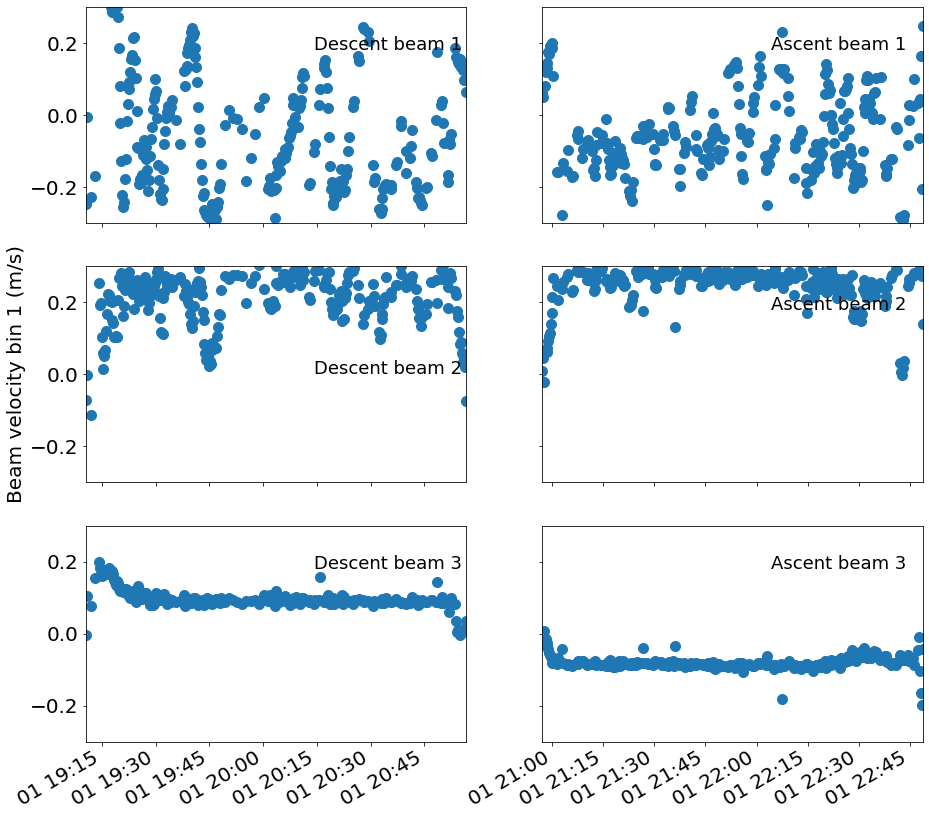

In [14]:
v_lim = 0.3
fig,ax = plt.subplots(3,2,figsize=(15,15), sharex='col', sharey='row')
ax = ax.ravel()
ax[0].scatter(foo.time,foo.vel_enu[:,0,0])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[1].scatter(bar.time,bar.vel_enu[:,0,0])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[2].scatter(foo.time,foo.vel_enu[:,0,1])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[3].scatter(bar.time,bar.vel_enu[:,0,1])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[4].scatter(foo.time,foo.vel_enu[:,0,2])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[5].scatter(bar.time,bar.vel_enu[:,0,2])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)

ax[0].set(ylim=[-v_lim, v_lim])
ax[2].set(ylim=[-v_lim, v_lim], ylabel='Beam velocity bin 1 (m/s)')
ax[4].set(xlim=[foo.time[0], foo.time[-1]], ylim=[-v_lim, v_lim])
ax[5].set(xlim=[bar.time[0], bar.time[-1]])

ax[0].text(0.6, 0.8, 'Descent beam 1',transform=ax[0].transAxes)
ax[1].text(0.6, 0.8, 'Ascent beam 1',transform=ax[1].transAxes)
ax[2].text(0.6, 0.5, 'Descent beam 2',transform=ax[2].transAxes)
ax[3].text(0.6, 0.8, 'Ascent beam 2',transform=ax[3].transAxes)
ax[4].text(0.6, 0.8, 'Descent beam 3',transform=ax[4].transAxes)
ax[5].text(0.6, 0.8, 'Ascent beam 3',transform=ax[5].transAxes)
fig.autofmt_xdate()

In [ ]:
sub_df = asc_df[asc_df.dive_no== 41.0]
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(sub_df.w_from_p, sub_df.u)
#ax.set(xlim=[-0.5, 0.5], ylim=[-0.5, 0.5])

In [ ]:
sub_df

In [ ]:
dive = mission_dict['0041a']
flagger = copy.deepcopy(dive.flag_bad_data)
for cell in range(np.size(flagger,1)):
    flagger[:,cell,:] = flagger[:,3,:]
dive_vel = copy.deepcopy(dive.vel_xyz)
dive_vel[:,1,0][:-1]

In [ ]:
np.round(edgetocentre(foo.vel_xyz[:,1,0]) - des_df.u.values,2)

In [ ]:
des_df.u

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,14), sharex=False)
ax = ax.ravel()
ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,0][:-1], label='x')
ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,1][:-1], label='y')
#ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,2][:-1], label='z')
ax[0].set(xlim=[0,0.2], ylim=[-0.4,0.4],ylabel='xyz water velocity from ADCP m/s')
ax[0].legend()
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,0][:-1], label='x')
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,1][:-1], label='y')
#ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,2][:-1], label='z')
ax[1].set(xlim=[-0.25,0.], ylim=[-0.4,0.4], xlabel='w from pressure m/s')
#savefig('xyz_vel_dive41')

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,14), sharex=False)
ax = ax.ravel()
ax[0].scatter(tl, -foo.measurement_z, c=foo.cor_beam[:,:,2],  label='x')
#ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,1][:-1], label='y')
#ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,2][:-1], label='z')
#ax[0].set(xlim=[0,0.2], ylim=[-0.4,0.4],ylabel='xyz water velocity from ADCP m/s')
ax[0].legend()
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,0][:-1], label='x')
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,1][:-1], label='y')
#ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,2][:-1], label='z')
ax[1].set(xlim=[-0.25,0.], ylim=[-0.4,0.4], xlabel='w from pressure m/s')
#savefig('xyz_vel_dive41')

In [ ]:
foo.cor_beam[:,:,2]
foo.measurement_z
tl = np.transpose(np.tile(foo.time, (15,1)))
tl2 = np.transpose(np.tile(bar.time, (15,1)))

In [ ]:
fig, ax = plt.subplots(figsize=(12,14))

mp0 = ax.scatter(tl, foo.measurement_z, c=foo.cor_beam[:,:,2], vmin=0, vmax=100,cmap='RdBu',s=10)
ax.scatter(tl2, bar.measurement_z, c=bar.cor_beam[:,:,2], vmin=0, vmax=100,cmap='RdBu',s=10)
fig.colorbar(ax = ax,mappable=mp0, label='Ping correlation %')
ax.set(xlim=[tl[0,0], tl2[-1,-1]], ylabel='z (m)')
savefig('correlation')

In [ ]:
fig, ax = plt.subplots(figsize=(12,14))

mp0 = ax.scatter(tl, foo.measurement_z, c=foo.beam_miss, vmin=0, vmax=2,cmap='RdBu_r',s=10)
ax.scatter(tl2, bar.measurement_z, c=bar.beam_miss, vmin=0, vmax=2,cmap='RdBu_r',s=10)
fig.colorbar(ax = ax,mappable=mp0, label='Beam miss (m)')
ax.set(xlim=[tl[0,0], tl2[-1,-1]], ylabel='z (m)')
savefig('beam_miss')

In [ ]:
foo.beam_miss

In [ ]:
np.shape(foo.measurement_z)

As above for enu velocites

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,14), sharex=False)
ax = ax.ravel()
ax[0].scatter(-foo.glider_w_from_p,foo.vel_enu[:,0,0][:-1], label='x')
ax[0].scatter(-foo.glider_w_from_p,foo.vel_enu[:,0,1][:-1], label='y')
#ax[0].scatter(-foo.glider_w_from_p,foo.vel_enu[:,0,2][:-1], label='z')
ax[0].set(xlim=[0,0.2], ylim=[-0.4,0.4],ylabel='water velocity from ADCP m/s')
ax[0].legend()
ax[1].scatter(-bar.glider_w_from_p,bar.vel_enu[:,0,0][:-1], label='x')
ax[1].scatter(-bar.glider_w_from_p,bar.vel_enu[:,0,1][:-1], label='y')
#ax[1].scatter(-bar.glider_w_from_p,bar.vel_enu[:,0,2][:-1], label='z')
ax[1].set(xlim=[-0.25,0.], ylim=[-0.4,0.4], xlabel='w from pressure m/s')
savefig('enu_vel_dive41')

In [ ]:
all_the_shear = np.empty((len(mission_dict),100,3))
all_the_amp = np.empty((len(mission_dict),100,3))

in_bin = np.empty((len(mission_dict), 100))
for i, dive in enumerate(mission_dict.keys()):
    all_the_shear[i,:,:] = mission_dict[dive].vel_referenced
    in_bin[i,:] = mission_dict[dive].no_in_bin
    all_the_amp[i,:] = mission_dict[dive].amp_binned


In [ ]:
np.shape(all_the_amp)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
nos = ax.pcolor(np.arange(0,len(overview.index)/2,0.5), np.arange(-1000,10,10),np.transpose(np.nanmean(all_the_amp,2)),vmin=30, vmax=40, cmap='RdBu')
ax.set(ylim=[-760,0], ylabel='z (m)', xlabel='Dive number', label='return_amp')
fig.colorbar(mappable=nos,ax=ax)
savefig('return_amp')

Check how many adcp velocity shear measurements were used in each cell of the velocity profile

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
nos = ax.pcolor(np.arange(0,len(overview.index)/2,0.5), np.arange(-1000,10,10),np.transpose(in_bin), vmin=0, vmax=100, cmap='viridis')
ax.set(ylim=[-760,0], ylabel='z (m)', xlabel='Dive number')
fig.colorbar(mappable=nos,ax=ax, label='number of shear estimates per bin', extend='max')
savefig('vels_per_10m_bin')

Plot the shear profiles

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15,30), sharex=True)
ax = ax.ravel()
ax[0].pcolor(np.transpose(all_the_shear[201:250,:,0]), cmap='RdBu_r', vmin=-0.5, vmax=0.5)
ax[1].pcolor(np.transpose(all_the_shear[201:250,:,1]), cmap='RdBu_r', vmin=-0.5, vmax=0.5)

-------------------
# Rough stuff